# Steve Chadwick
## Final Project

*Note: my comments are all italisized to differentiate them from the comments provided by Professor Farr.*

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import pymc3 as pm

from scipy.stats.distributions import norm

import seaborn as sns

# Gamma Ray Bursts

In the 1960's the US began the [Vela satellite program](https://en.wikipedia.org/wiki/Vela_(satellite)), sending gamma ray detectors into space with the intention of monitoring the USSR for secret nuclear tests violating the Nuclear Test Ban Treaty during the cold war (image credit:[Los Alamos National Laboratory](https://en.wikipedia.org/wiki/Vela_satellite#/media/File:Vela5b.jpg)).

<img src="https://imagine.gsfc.nasa.gov/Images/vela5b/vela5b_5.gif" width="250" alt="Vela"/>

These satellites picked up numerous bursts of gamma rays, but they were unlike anything seen during nuclear testing.

<img src="https://news.psu.edu/sites/default/files/styles/photo_gallery_large/public/Neutron_Star_Merger_Still_2.jpg" width="500" alt="GRB"/>

These bursts turned out to be cosmic, not terrestrial, in origin.  Know referred to as gamma ray bursts (GRBs), they are the brightest electromagnetic events known to happen in the universe (image credit:[NASA](https://fermi.gsfc.nasa.gov/)).

NASA's most recent mission to study these bursts is the Fermi Gamma Ray Space Telescope, which launched in 2008 (image credit:[NASA](https://www.nasa.gov/content/fermi/overview)).

<img src="https://www.nasa.gov/sites/default/files/fermi.jpg" alt="Fermi" width="500"/>

To date, Fermi has detected more than 2000 GRBs.  In this project we're going to look at its observations of these GRBs, particularly how long the bursts last, to develop a better understanding of what these GRBs are.

## Load Data

In this repository I've included data downloaded directly from NASA's [Fermi GBM Burst Catalog](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermigbrst.html).  There are lots more data available for these events, but we're going to focus on the distribution of `T90`, the time taken to accumulate 90% of the burst fluence starting at the 5% fluence level (fluence is the radiant energy received by a surface -- the gamma ray detectors in this case -- per unit area, with units $\mathrm{J}/\mathrm{m}^2$).

In [2]:
# Lets establish a data type.  We'll be storing event names and T90 measurements
dtype=[('event', 'S12'), ('T90', np.float64)]
data = np.genfromtxt('Fermi_GRBs.txt', usecols=(1,4), skip_header=5, delimiter='|', dtype=dtype)

print(data)
print("{} events read.".format(len(data)))

[(b'GRB140323433',  111.426) (b'GRB100325246',    8.192)
 (b'GRB100507577',   44.033) ..., (b'GRB121117018',  331.782)
 (b'GRB160609690',    1.6  ) (b'GRB090222179',   17.408)]
2210 events read.


There is one burst without a `T90` measurement, so let's remove it from our dataset.

In [3]:
data = data[~np.isnan(data['T90'])]
print("{} events left.".format(len(data)))

2209 events left.


# Distribution of `T90`

Now let's take a look at the distribution of `T90`.

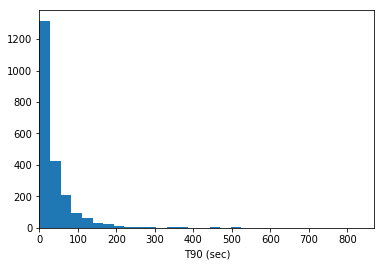

In [4]:
# Store T90 values in a dedicated array for convenience
T90 = data['T90']

plt.hist(T90, bins=30)

plt.xlabel('T90 (sec)')
plt.xlim(xmin=0);

It's hard to see any detail here, so let's use a log scale.

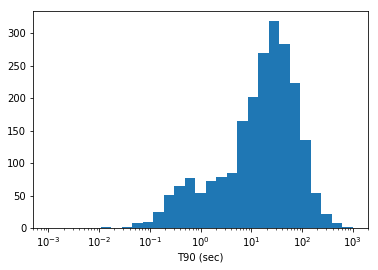

In [5]:
fig, ax = plt.subplots()

nbins = 30
bins = np.logspace(-3, 3, nbins)
plt.hist(data['T90'], bins=bins)
plt.xlabel('T90 (sec)')
ax.set_xscale('log');

This looks kind of Gaussian...ish.  Let's try modeling it with a normal distribution.

Since this is $\log_{10} (\mathrm{T90})$ we should technically be using a log-Normal distribution, but since we've already used standard Gaussian mixture models we'll just analyze the $\log$ of the data.

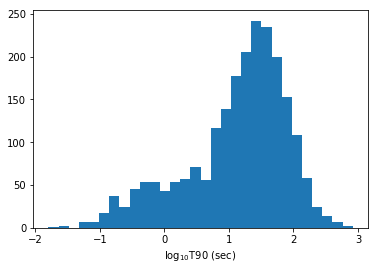

In [6]:
logT90 = np.log10(data['T90'])
plt.hist(logT90, bins=30)
plt.xlabel('$\log_{10}\mathrm{T90}$ (sec)');

# Results

Point totals for each section (481/581) are provided.

## Gaussian model (45/25)

Using the `logT90` dataset defined above, build a `PyMC3` Gaussian distribution model.  Describe each component of your model, describe the priors you use and why, identify which component is the likelihood.

*To create a Gaussian model for this data we need to find a mean and standard deviation which best fits the data, thus we'll use those two parameters as our priors. We don't want to be restrictive with these though so we'll choose a uniform distribtuion for the mean (mu) that starts at the minimum of the data and ends at the max of the data. This ensures that the mean could be any value in the data set. We dont know what the standard deviation is but the spread of the data looks to be about -2 to 3, so we can infer that the standard deviation will be less than 5. To be safe though, we'll choose a half normal distribution of 10, which will surely be a big enough range. Using the mu and standard deviation described by a uniform and half normal distributuion distribution we can create our likelihood, which is a normal distribution with parameters mu, sd, and our observed data. This likelihood will have a mean and standard deviation which is what we're looking for.*

In [7]:
# Gaussian model here (15/10)

with pm.Model() as Gaussian_Model:
    
    # Priors:
    mu = pm.Uniform('mu', lower=logT90.min(), upper=logT90.max())
    sd = pm.HalfNormal('sd', sd=10)
    
    # Likelihood
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=logT90)

Sample the posterior for this model.  Show your traces and discuss them.  Did you get good sampling?  Are you sure your priors aren't too restrictive?

*On the right side we can see the traceplots for the Gaussian model above. We can see that these chains look very healthy since the they are dense and do not wander too far in any direction. We can also see from the right side of the traceplot that both chains settled on very similar distributions. We also can see that our priors were not too restrictive because the marginal posterior plots are distributions around a value much more specific than the values offered by the priors. That is, the prior for mu was a uniform distribution ranging from the smallest data point (about -2) to the largest data point (about 3) and the posterior distribution is around 1.125 with a standard deviation much smaller than that described by the prior. The sd posterior plot shows a distribution about 0.78 with nontrivial probabilites ranging from 0.74 to 0.83, which is much more specific and confident than the prior which was a halfnormal distribution with a standard deviation of 10.*

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:05<00:00, 1742.75draws/s]


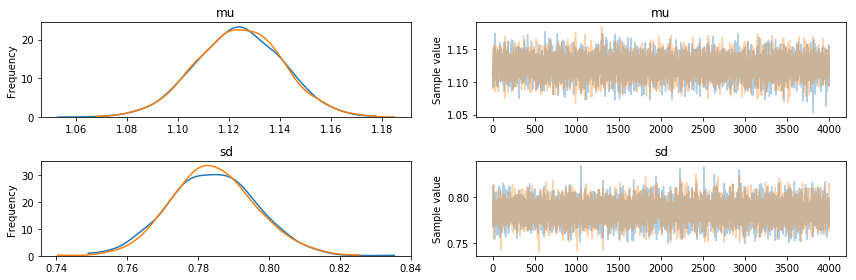

In [8]:
# Trace plots and discussion here (10/5)

with Gaussian_Model:
    Gaussian_Trace = pm.sample(4000, cores = 2)
pm.traceplot(Gaussian_Trace);

*We can also verify how healthy our chains are by looking at the gelman rubin statistics, autocorrelation plots, and our effective number of independent samlples. All of these look great, our gelman rubin stats are under 1.01, our autocorrelation plots are essentially only tails, and our effective number of samples is well into the thousands.*

In [9]:
pm.gelman_rubin(Gaussian_Trace)

{'mu': 0.99989297281066847, 'sd': 0.99988481033215781}

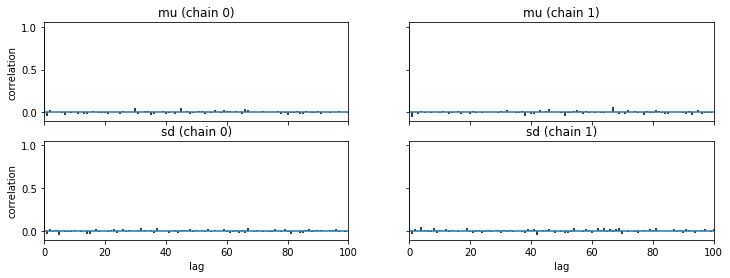

In [10]:
pm.autocorrplot(Gaussian_Trace);

In [11]:
pm.effective_n(Gaussian_Trace)

{'mu': 8768.7851642950573, 'sd': 8360.4300518269447}

Show the marginal posterior estimates for the parameters in your model.  What have we learned?

In [12]:
# Marginal posterior plots here (10/5)

*Below are the marginal posterior estimates for our Gaussian model which are the same graphs as those produced on the left side by the pm.traceplot function call above. We can see that the samples have converged confidently on a value around 1.125 for the mean and a value around 0.78 for the standard deviation of the Gaussian distribution described in our likelihood. We can now use these values to generate data based on a Gaussian distribution to see if our model represents the real data well.*

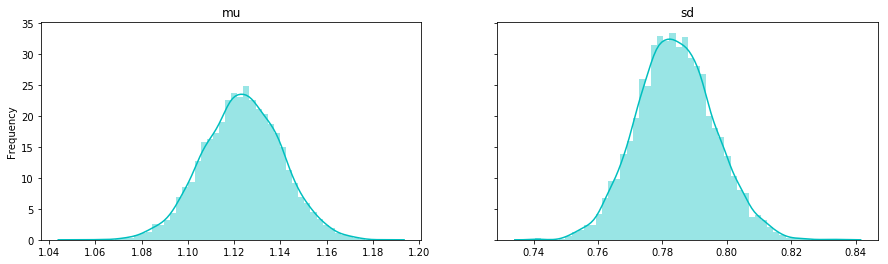

In [13]:
fig, (ax1, ax2)  = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(15,4))

sns.distplot(Gaussian_Trace['mu'], color='c', ax=ax1)
ax1.set_ylabel("Frequency")
ax1.set_title("mu")

sns.distplot(Gaussian_Trace['sd'], color = 'c', ax=ax2)
ax2.set_title("sd");

How well does your model fit the data.  You can show this by either plotting the posterior constraints for your model with the data, or doing posterior predictive checks and simulating data from your constrained model and comparing to the actual data.

*Using np.random.normal we can genderate random normal samples from the mean and standard deviation we found with our Gaussian Model. We can generate the same number of samples as we have data points and then compare them to the real data to analyize our fit. Based on the histogram below, we can see that our generated data doesn't do a great job of mimicing our real data. The real data appears to have a more complicated distribution that just a Gaussian distribution and thus our Gaussian model doesn't generate data according to the nuances of the real data.*

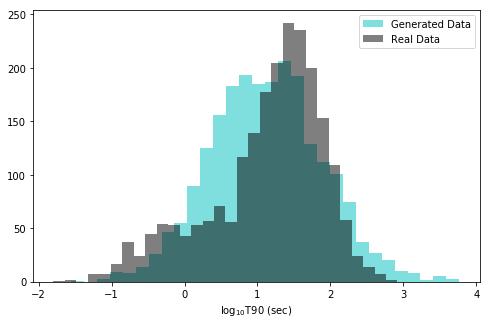

In [14]:
# Compare to data here (10/5)
mean = np.median(Gaussian_Trace['mu'])
sd = np.median(Gaussian_Trace['sd'])

normal_dist = np.random.normal(mean,sd, len(logT90))

fig, ax = plt.subplots(figsize=(8,5))

ax.hist(normal_dist, bins = 30, alpha=.5, color='c', label='Generated Data')
ax.hist(logT90, bins= 30, alpha = .5, color='k', label='Real Data')
ax.legend()
ax.set_xlabel('$\log_{10}\mathrm{T90}$ (sec)');

## Gaussian mixture model (55/55)

Now lets use a 2-component Gaussian mixture model to better understand the data. Build a 2-component *marginalized* Gaussian mixture model. Describe each component of your model, describe the priors you use and why, identify which component is the likelihood.

*Now, since we've seen from the generated data that our single component Gaussian model doesn't represtent the data well, we'll try a 2 component Gaussian model. To do this we'll definde the number of components as 2 and use that number to determine the number of weights, means, and standard deviations.*

*In the model below we want priors for two differently weighted Gaussian distributions. Thus, we define a Dirichlet distribution for the weights, which is the mulitdimensional beta distribution and we set a = 1 for each component. This essentially creates a unifrom weights prior with 2 components. Next, we define our 2 mean values for the 2 component Gaussian as a uniformily distributed distribution from the minimun data point to the maximum data point. Then, we define our 2 standard deviations for the 2 component Gaussian as a halfnormal distirbution with a standard deviation of 5, which should be more than enough to ensure unrestrictive priors. Next, we use a switch function and a potential function that says if the first mean is less than the second mean the probability should be negative infinity. This makes sure that the chains alway choose the same mean and avoids the exchange symmetry.*

*Now, with our priors in place we can use a Normal Mixture distribution to define our likelihood. This will create 2 Gaussian distributions with weights according to the prior weights, means according to the prior mean and standard deviations according to the prior standard deviations. This will also take our observed data into account so that the two Gaussians model the data.*

In [15]:
# Gaussian mixture model here (15/15)

component_num = 2

with pm.Model() as Mixture_Model:
    # Priors:
    w = pm.Dirichlet('w', a=np.ones(component_num), shape=component_num, testval=[.2,.8])
    
    mu = pm.Uniform('mu', lower=logT90.min(), upper=logT90.max(), shape=component_num, testval=[0,1.5])
    sd = pm.HalfNormal('sd', sd=5, shape=component_num)
    
    # avoid the exchange symmetry to make sampling easier
    
    switchs0 = pm.math.switch(mu[1]-mu[0] < 0, -np.inf, 0)
    order_means_potential0 = pm.Potential('order_mu_potential0', pm.math.sum(switchs0))
    
    # Likelihood:
    mixture = pm.NormalMixture('obs', w, mu=mu, sd=sd, observed=logT90)

Sample the posterior for this model.  Show your traces and discuss them.  Did you get good sampling?  Are you sure your priors aren't too restrictive?

*Below on the right are the traceplots for the Mixture Model defined above. When looking at the sampling we can see that the chains look fairly healthy and don't wander very much. We can also see that both chains seem to oscilate about the same sample value which indicates that the chains came to the same conclusions organically.*

*The priors weren't to restrictive since the samples converged on specific values with much higher confidences than offered by the priors. The weights prior was a Dirichlet uniform distribution and the posterior weights are distributed in a very non-uniform way. The mu prior uniformilly spanned the whole data set and we can see that the prosterior distribiutions settle on specific values in the data set. Lastly, the posterior sd values are far more specific than the prior halfnormal with standard deviation of 10.*

In [16]:
# Trace plots and discussion here (10/10)

with Mixture_Model:
    Mixture_Trace = pm.sample(25000, pm.Metropolis(), tune=5000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mu]
>Metropolis: [w]
Sampling 2 chains: 100%|██████████| 60000/60000 [01:04<00:00, 932.40draws/s] 
The number of effective samples is smaller than 10% for some parameters.


*Note that if this model's trace is re-run it might need to be re-run more than once if the sampling  isn't good. Re-running two to three times should result in a plot similar to this.*

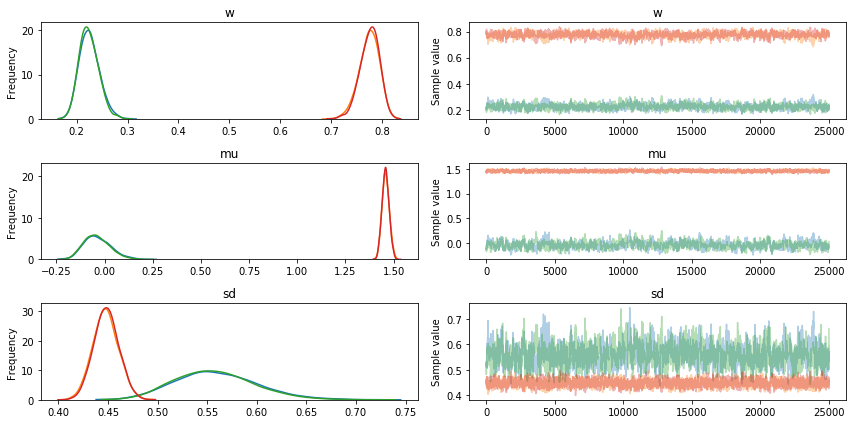

In [17]:
pm.traceplot(Mixture_Trace[0:]);

*When further examining our sampling we can see the Gelman Rubin statistics are quite good and all below 1.01, but the effective number of samples and the autocorrelation plots show that more samples would be better (we want autocorrelation plots to quickely decay to zero and effective number of independent samples in the 1000s)*

In [18]:
pm.gelman_rubin(Mixture_Trace)

{'w': array([ 1.00092559,  1.00092559]),
 'mu': array([ 1.00129438,  1.00038507]),
 'sd': array([ 1.00091734,  1.00086835])}

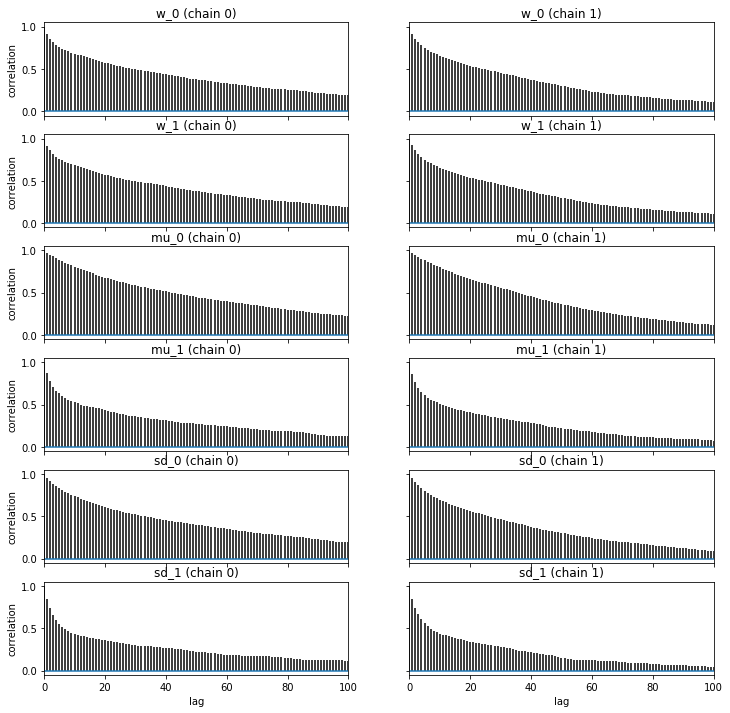

In [19]:
pm.autocorrplot(Mixture_Trace);

In [21]:
pm.effective_n(Mixture_Trace)

{'w': array([ 543.40118174,  543.40118174]),
 'mu': array([ 447.76953904,  766.61672881]),
 'sd': array([ 512.10083471,  905.27383677])}

Show the marginal posterior estimates for the parameters in your model.  What have we learned?

*Looking at the marginal posterior plots we can see that the 2 component Gaussian model found one Gaussian distribution to have a mean of about -0.15, a standard deviation of about 0.55, and a weight of 0.22. The model also found a second Gaussian distribution described by a mean of about 1.45, a standard deviation of about 0.45 and a weight of 0.78.*

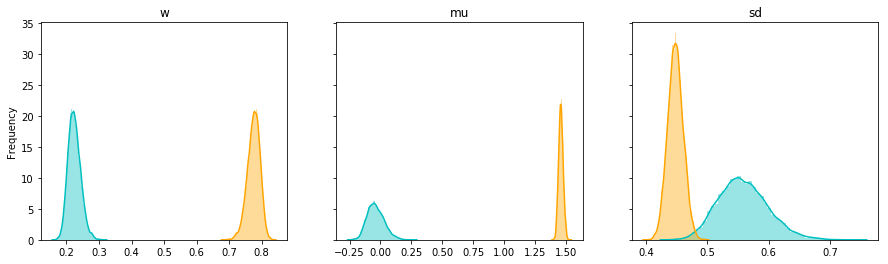

In [22]:
# Marginal posterior plots here (10/10)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, sharey=True, figsize=(15,4))

sns.distplot(Mixture_Trace['w'][:,0], color='c', ax=ax1)
sns.distplot(Mixture_Trace['w'][:,1], color='orange', ax=ax1)
ax1.set_ylabel("Frequency")
ax1.set_title("w")

sns.distplot(Mixture_Trace['mu'][:,0], color='c', ax=ax2)
sns.distplot(Mixture_Trace['mu'][:,1], color='orange', ax=ax2)

ax2.set_title("mu")

sns.distplot(Mixture_Trace['sd'][:,0], color='c', ax=ax3)
sns.distplot(Mixture_Trace['sd'][:,1], color='orange', ax=ax3)

ax3.set_title("sd");


How well does your model fit the data.  You can show this by either plotting the posterior constraints for your model with the data, or doing posterior predictive checks and simulating data from your constrained model and comparing to the actual data.  How is your Gaussian mixture model performing compared to single Gaussian model above?

*To create the graph below we must generate two normal distribution based on the marginal posterior plots. We'll use the the means and standard deviations based on each Gaussian found by the mixture model and then choose our number of samples based on the weights of each Gaussian. This way, we have about the same number of random sample as our data set and we have a proportional number from each gaussian according to the weight of that distribution.*

*Once we've generated a single distribution by concatinating the two distributions defined by our mixture model we can plot that over the real data and normalize both. We see the results are two very similar looking distributions, this implies that our model did a good job of describing the data. This model does a much better job than the single component Gaussian since it follows the contures of the data much more closely.*

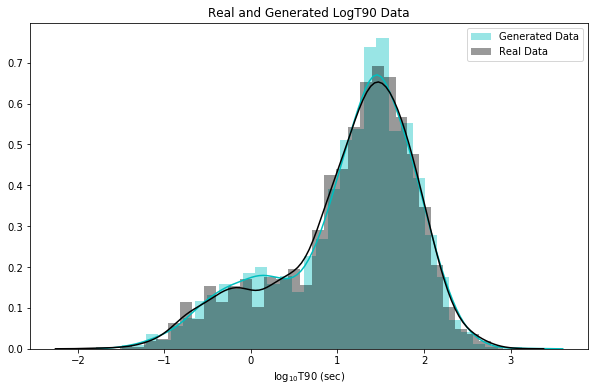

In [23]:
# Compare to data here (10/10)

def median_val(trace, name, place):
    '''This function finds the median value from a trace'''
    return np.median([i[place] for i in trace[name]])

weight0 = median_val(Mixture_Trace, 'w', 0)
weight1 = median_val(Mixture_Trace, 'w', 1)

mu0 = median_val(Mixture_Trace, 'mu', 0)
mu1 = median_val(Mixture_Trace, 'mu', 1)

sd0 = median_val(Mixture_Trace, 'sd', 0)
sd1 = median_val(Mixture_Trace, 'sd', 1)

normal_dist0 = np.random.normal(mu0,sd0, int(weight0*len(logT90)))
normal_dist1 = np.random.normal(mu1,sd1, int(weight1*len(logT90)))

# concatonate the two distributions to make one distribution.
normal_dist = np.concatenate((normal_dist0, normal_dist1))

fig, ax = plt.subplots(figsize=(10,6))

sns.distplot(normal_dist, color = 'c',  label='Generated Data')
sns.distplot(logT90, color = 'k', label='Real Data')
ax.legend()
ax.set_title('Real and Generated LogT90 Data')
ax.set_xlabel('$\log_{10}\mathrm{T90}$ (sec)');

The two subpopulations you have constrained here are thought to arise from very different processes.  The short-duration population, creatively named _short gamma ray bursts_, are believed to be from compact binary mergers with neutron stars (GW170817/GRB170817A is the first confirmation of this).  The _long gamma ray bursts_ are instead the death of massive stars, and are often associated with core-collapse supernovae.

From your posterior estimates above, what can you say about the fraction of detected GRBs that are short GRBs?

*Since we believe that there are two different types of subpopulations contributing to the data we can infer that the first Gaussian of our mixture model represents the short gamma ray bursts and the second Gaussian represents the long gamma ray bursts. Based on this logic, the fraction of short gamma ray bursts should be modeled by the weight of the first Gaussian distribution, thus we'd expect about 22.31% of the data to come from short gamma ray bursts.*

In [24]:
# Posterior estimate for detected fraction of short GRBs (5/5)

weight0

0.22317879519138656

Finally, lets determine the class of some specific GRBs.  For this you will need to build a new model with latent variables for the subpopulation type of each GRB.

What is the most likely GRB type for `GRB110717180`?  How certain is this association?  What about `GRB080808451`?

*Our new model is essentially the same as our mixture model but here we will use a Categorical function to categorize each data point and provide a weight as to which Gaussian the data point is most likely to come from. We will also use a single normal distribution for the likelihood for each point rather than a mixture distribution. Given the number of data points this will take a long time so be careful if re-running.*

In [25]:
# Posterior estimates for associations of specific GRBs (5/5)

component_num = 2

with pm.Model() as Latent_Mixture_Model:
    
    # Subpoulation weights
    w = pm.Dirichlet('w', a=np.ones(component_num), shape=component_num, testval=[.2,.8])
    
    # Priors for subpoulations
    mu = pm.Uniform('mu', lower=logT90.min(), upper=logT90.max(), shape=component_num, testval=[0,1])
    sd = pm.HalfNormal('sd', sd=5, shape=component_num)
    
    # avoid the exchange symmetry to make sampling easier
    
    switchs = pm.math.switch(mu[1]-mu[0] < 0, -np.inf, 0)
    order_means_potential = pm.Potential('order_mu_potential', pm.math.sum(switchs))
    
    # Association for subpopulations
    category = pm.Categorical('category', p=w, shape=len(logT90))
     
    # Likelihood for each value
    points = pm.Normal('obs', mu=mu[category], sd=sd[category], observed=logT90)

In [26]:
with Latent_Mixture_Model:
    Latent_Mixture_Trace = pm.sample(2000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sd, mu, w]
>BinaryGibbsMetropolis: [category]
Sampling 2 chains: 100%|██████████| 5000/5000 [24:21<00:00,  1.74draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


*Here we can see the traceplot for our new model, as expected it looks very similar to our mixture model. The chains do not  look very good but we already know that they would look okay with more time given the previous traceplot. Note that this takes a long time to render given the size of the data set.*

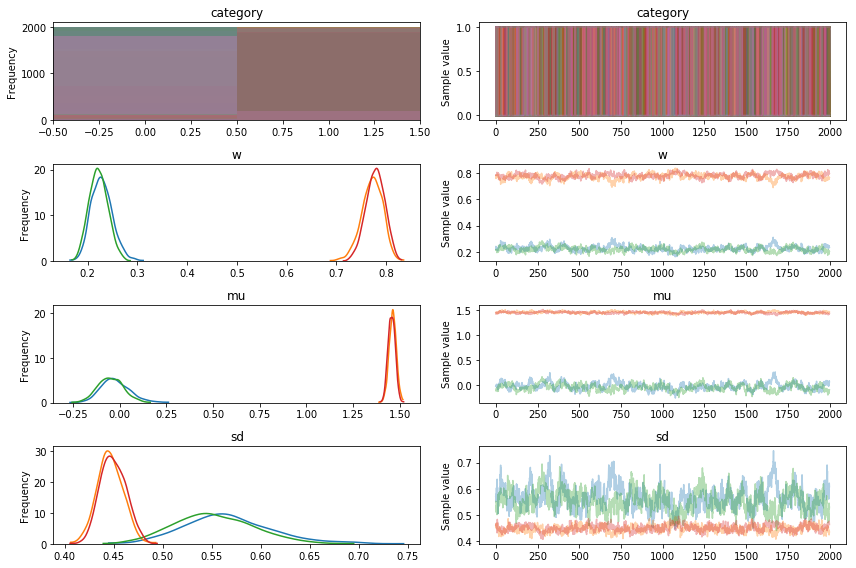

In [27]:
pm.traceplot(Latent_Mixture_Trace);

*Now, we want to find the weights two data points described above, to do this we'll take the transpose of the data set (so that each column is a data point and each row is the sample). Now we can pick out the same data point from each sample. Next, we'll find the data point's location in the data, that index will allow us to find the data point in the posterior. Then, we'll find the number of times the data point was in category 0 and the number of times the data point was in category 1. Taking the average of those numbers will tell us the likelihood of each point being in each Gaussian, which tells us which distribution we think it came from and how certain we are.*

In [28]:
# Transpose the categorical data.
cat_trace = Latent_Mixture_Trace['category'].T
cat_trace.shape

(2209, 4000)

In [29]:
(cat_trace[0] == 0).shape

(4000,)

In [30]:
# Find the given data point's index
names = [i[0] for i in data]
for i, name in enumerate(names):
    if name == b'GRB110717180':
        GBM0 = i
        
for i, name in enumerate(names):
    if name == b'GRB080808451':
        GBM1 = i

# Find the average number of times the data point was in each category.

print('GRB110717180: Distribution 0 probability = {}, Distribution 1 probability = {} .'
      .format(round(np.mean(cat_trace[GBM0] == 0),4),
              round(np.mean(cat_trace[GBM0] == 1),4)))
print('GRB080808451: Distribution 0 probability = {}, Distribution 1 probability = {} .'
      .format(round(np.mean(cat_trace[GBM1] == 0),4),
              round(np.mean(cat_trace[GBM1] == 1),4)))

GRB110717180: Distribution 0 probability = 1.0, Distribution 1 probability = 0.0 .
GRB080808451: Distribution 0 probability = 0.3767, Distribution 1 probability = 0.6232 .


In [31]:
for i in data:
    if i[0] == b'GRB110717180':
        print(i)
    if i[0] == b'GRB080808451':
        print(i)

(b'GRB080808451',  4.352)
(b'GRB110717180',  0.112)


*Based on the samples, we are extremely confident (about 100%) the GRB110717180 gamma ray burst came from the first distribtion, this makes sense because the first distribtion models the short gamma ray bursts and the time of the GRB110717180 is 0.112 seconds, which is fast. The second gamma ray burst, GRB080808451, is likely from the the second distribtuion (the long gamma ray bursts), but we are only 62.32% sure about this. This also makes sense because the GRB080808451 is 4.352 seconds, which is not short but not long either relative to the other data.*

## Conclusion:

*It appears the 2 component Gaussian model does the better job of modeling the data although there are some slight differences in the generated data and the actual data and it would be worth it to experiment with different models given more time. In particular, 3 or 4 component Gaussian models might be a little more sensitive to the minor variations in the data's distribution. It is also possible that Gaussian distributions aren't the best model for this data, perhaps a combination of gamma and normal distributions or some other combination of distributions would be a better fit. Regadless, the two component Gaussian does a good job of fitting the data and makes physical sense based on the combination of short and long gamma ray bursts in the data.*